# Record a Dataset

Using what you've learned previously, you can now easily record a dataset of states and actions for one episode. You can use busy_wait to control the speed of teleoperation and record at a fixed fps (frame per seconds).

In [5]:
# First, initialize the robot
from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig
from lerobot.common.robot_devices.motors.configs import DynamixelMotorsBusConfig

leader_config = DynamixelMotorsBusConfig(
    port="/dev/tty.usbmodem58760435371",
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl330-m077"),
        "shoulder_lift": (2, "xl330-m077"),
        "elbow_flex": (3, "xl330-m077"),
        "wrist_flex": (4, "xl330-m077"),
        "wrist_roll": (5, "xl330-m077"),
        "gripper": (6, "xl330-m077"),
    },
)

follower_config = DynamixelMotorsBusConfig(
    port="/dev/tty.usbmodem58760433811",
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl430-w250"),
        "shoulder_lift": (2, "xl430-w250"),
        "elbow_flex": (3, "xl330-m288"),
        "wrist_flex": (4, "xl330-m288"),
        "wrist_roll": (5, "xl330-m288"),
        "gripper": (6, "xl330-m288"),
    },
)

robot = ManipulatorRobot(
    KochRobotConfig(
        leader_arms={"main": leader_config},
        follower_arms={"main": follower_config},
        calibration_dir=".cache/calibration/koch",
        cameras={
            "usb": OpenCVCameraConfig(0, fps=30, width=640, height=480),
            "macbook": OpenCVCameraConfig(1, fps=30, width=640, height=480),
        },
    )
)
robot.connect()

Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.


Now try this code to record 30 seconds at 60 fps:

In [2]:
import time
from lerobot.scripts.control_robot import busy_wait
from tqdm import tqdm

record_time_s = 10
fps = 60

states = []
actions = []
for _ in tqdm(range(record_time_s * fps)):
    start_time = time.perf_counter()
    observation, action = robot.teleop_step(record_data=True)

    states.append(observation["observation.state"])
    actions.append(action["action"])

    dt_s = time.perf_counter() - start_time
    busy_wait(1 / fps - dt_s)

# Note that observation and action are available in RAM, but
# you could potentially store them on disk with pickle/hdf5 or
# our optimized format `LeRobotDataset`. More on this next.

/opt/homebrew/anaconda3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 600/600 [00:10<00:00, 59.32it/s]


In [7]:
# Let's disconnect the robot
robot.disconnect()

Importantly, many utilities are still missing. For instance, if you have cameras, you will need to save the images on disk to not go out of RAM, and to do so in threads to not slow down communication with your robot. Also, you will need to store your data in a format optimized for training and web sharing like LeRobotDataset. More on this in the next section.

## 1. Use the record function

**Important:** To avoid issues, execute the following commands in the terminal at the root of the repository instead of this notebook.

You can use the record function from lerobot/scripts/control_robot.py to achieve efficient data recording. It encompasses many recording utilities:

1. Frames from cameras are saved on disk in threads, and encoded into videos at the end of each episode recording.

2. Video streams from cameras are displayed in window so that you can verify them.

3. Data is stored with LeRobotDataset format which is pushed to your Hugging Face page (unless --control.push_to_hub=false is provided).

4. Checkpoints are done during recording, so if any issue occurs, you can resume recording by re-running the same command again with `--control.resume=true`. You will need to manually delete the dataset directory if you want to start recording from scratch.

5. Set the flow of data recording using command line arguments:

   * --control.warmup_time_s=10 defines the number of seconds before starting data collection. It allows the robot devices to warmup and synchronize (10 seconds by default).

   * --control.episode_time_s=60 defines the number of seconds for data recording for each episode (60 seconds by default).

   * --control.reset_time_s=60 defines the number of seconds for resetting the environment after each episode (60 seconds by default).

   * --control.num_episodes=50 defines the number of episodes to record (50 by default).

6. Control the flow during data recording using keyboard keys:

   * Press right arrow -> at any time during episode recording to early stop and go to resetting. Same during resetting, to early stop and to go to the next episode recording.

   * Press left arrow <- at any time during episode recording or resetting to early stop, cancel the current episode, and re-record it.

   * Press escape ESC at any time during episode recording to end the session early and go straight to video encoding and dataset uploading.

7. Similarly to teleoperate, you can also use the command line to override anything.

Before trying record, if you want to push your dataset to the hub, make sure you've logged in using a write-access token, which can be generated from the Hugging Face settings: https://huggingface.co/settings/tokens

Then you can log in from the command line with:



Also, store your Hugging Face repository name in a variable (e.g. cadene or lerobot). For instance, run this to use your Hugging Face user name as repository:

If you don't want to push to hub, use --control.push_to_hub=false.

**Important:** It is good to contribute to and engage with the community by pushing your datasets to the hub. But your dataset is completely public so make sure you are not recording yourself or others without permission.

Suggestion: First try the command below where you don't push to hub. If everything works and you feel confident and comfortable with recording a full dataset, then you can push to hub by using --control.push_to_hub=true.

Now run this to record 2 episodes.

**Important:** Make sure to copy the calibration files from the previous section to the .cache/calibration/koch directory in the root of the repository.

Troubleshooting:
- If you get an "FileExistsError" for the .cache/huggingface/lerobot/\${HF_USER}/koch_test directory, you can delete it and run the command again. Alternatively you can resume recording by running the same command again with --control.resume=true. Also, you can rename the dataset using --control.repo_id=\${HF_USER}/your_new_dataset_name.
- If you get "Unknown encoder 'libsvtav1'", remove the conda ffmpeg installation if you have one.

## 2. Advice for Recording a Dataset

Once you're comfortable with data recording, it's time to create a larger dataset for training. A good starting task is grasping an object at different locations and placing it in a bin. We suggest recording at least 50 episodes, with 10 episodes per location. Keep the cameras fixed and maintain consistent grasping behavior throughout the recordings.

In the following sections, you’ll train your neural network. After achieving reliable grasping performance, you can start introducing more variations during data collection, such as additional grasp locations, different grasping techniques, and altering camera positions.

Avoid adding too much variation too quickly, as it may hinder your results.

In the coming months, we plan to release a foundational model for robotics. We anticipate that fine-tuning this model will enhance generalization, reducing the need for strict consistency during data collection.

You can look for other LeRobot datasets on the hub by searching for LeRobot tags: https://huggingface.co/datasets?other=LeRobot

When you set push_to_hub to true, after recording, your dataset will be uploaded to the hub under your account with the name for the repo_id you provided.

Use this code to test your camera positioning (you may need toinitialize the robot again with the code at the top of this notebook):

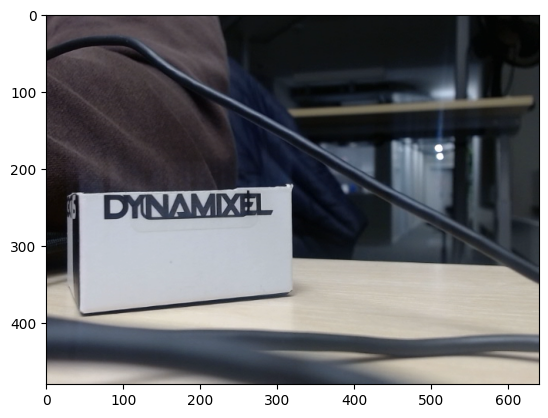

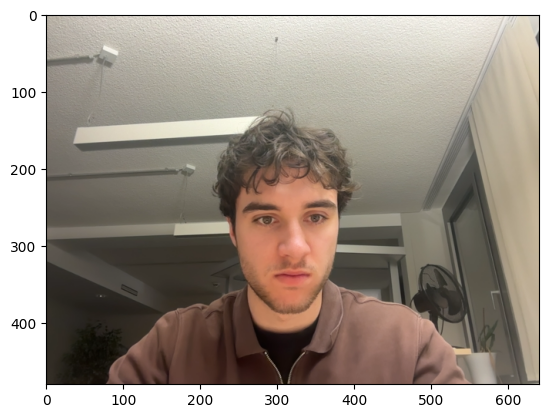

In [6]:
import matplotlib.pyplot as plt

image_usb = robot.cameras["usb"].read()
image_macbook = robot.cameras["macbook"].read()

plt.imshow(image_usb)
plt.show()
plt.imshow(image_macbook)
plt.show()

## 3. Visualize your recorded episodes

Run the following command. This will launch a local web server where the camera outputs and the motor orientations for each recorded episode are available.

Note: You might need to add `--local-files-only 1` if your dataset was not uploaded to hugging face hub.

Troubleshoot: If you get an "OSError: [Errno 30] Read-only file system: '/koch_test'", then you might need to set your HF_USER env variable (see above)

## 4. Replay episode on your robot with the replay function

A useful feature of lerobot/scripts/control_robot.py is the replay function, which allows to replay on your robot any episode that you've recorded or episodes from any dataset out there. This function helps you test the repeatability of your robot's actions and assess transferability across robots of the same model.

To replay the first episode of the dataset you just recorded, run the following command:

Your robot should replicate movements similar to those you recorded.

Nice, you now know how to record datasets 🥳🎉

The next step is to train a policy with these datasets.